## The geophilus electricus
Precision farming requires knownledge of clay and water content in three dimensions. Electrical resistivity is a sensible proxy parameter and can be determined by geoelectrical measurements.
For routine investigating of soils at large area, Lück & Rühlmann (2013) developed an instrument called *Geophilus electricus* that carries out geoelectric measurements while being trailed behind a truck. It uses the so-called equatorial dipole-dipole array where the current dipole and the measuring dipole are arranged in parallel, realized by steel wheels. 

For every current dipole injection, five (1st generation, 2013 and 3rd generation, 2020) or six (2nd generation, 3017) potential dipoles are measured parallel.
The distance between the dipoles was first (1st, 2nd) chosen 0.5m and later (v3) increased to 0.6m. We are illustrating the 1D and 3D sensitivity distributions. The geometry is given by dipole length a and the dipole distance b:

    A---c---M1--c---M2--c---M3--c---M4--c---M5
    |       |       |       |       |       |
    |       |       |       |       |       |
    a       a       a       a       a       a
    |       |       |       |       |       |
    |       |       |       |       |       |
    B---c---N1--c---N2--c---N3--c---N4--c---N5

In [1]:
a = 1.0
c = 0.6  # v1/v2, 0.6 for v3
nMN = 5  # 6 for v2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
from pygimli.viewer import pv
%matplotlib notebook

In [3]:
b = np.arange(1, nMN+1) * 0.6
bmVec = np.sqrt(b**2+a**2)

The geometric factor is (Guillemotau et al., 2017)
$$ K = \frac{2\pi}{1/AM-1/BM-1/AN+1/BN} = \frac{\pi}{1/AM-1/BM} = \frac{2\pi}{1/b - 1/\sqrt{a^2+b^2}}= \frac{\pi b}{1-b/\sqrt{a^2+b^2}} $$
where $b=i\cdot c$

In [4]:
k = np.pi * b / (1-b/np.sqrt(a**2+b**2))
print(k)

[  3.88246985  16.26513072  44.93598519  98.01769079 183.659074  ]


The 1D sensitivity function for a pole-pole measurement is (Günther, 2004)
$$ s(z) = \frac{z}{\sqrt{a^2+z^2}^3} $$
and therefore for a four-electrode array
$$ s(z) = \frac{z}{\sqrt{AM^2+z^2}^3} - \frac{z}{\sqrt{BM^2+z^2}^3} - \frac{z}{\sqrt{AN^2+z^2}^3} + \frac{z}{\sqrt{AN^2+z^2}^3} $$
We compute this and obtain the same results as Lück & Rühlmann (2013, Fig. 2):

<IPython.core.display.Javascript object>


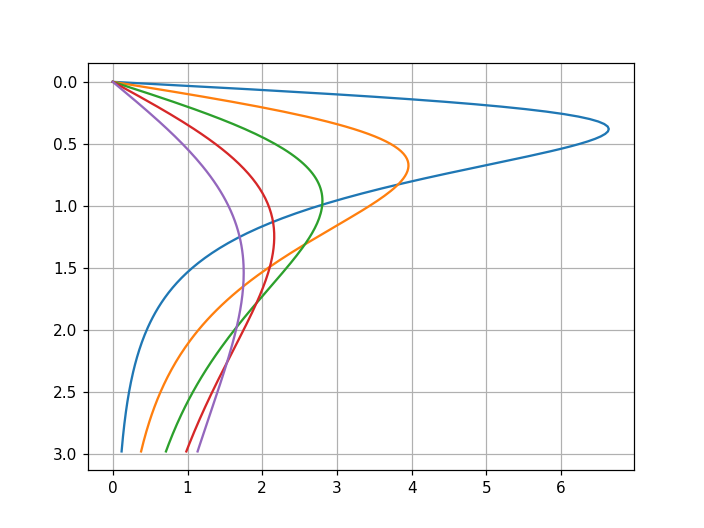

AM=0.6, zMax=0.38
AM=1.2, zMax=0.68
AM=1.8, zMax=0.96
AM=2.4, zMax=1.24
AM=3.0, zMax=1.54


In [5]:
z = np.arange(0, 3.0, 0.02)
for am, bm, kk in zip(b, bmVec, k):
    s = 2 * (z / np.sqrt(am**2+z**2)**3 - z / np.sqrt(bm**2+z**2)**3) * kk
    plt.plot(s, z)
    # plt.plot(s/max(s), z)
    print("AM={:.1f}, zMax={:.2f}".format(am, z[np.argmax(s)]))
    
plt.gca().invert_yaxis()
plt.grid()

Next, we will have a look at the 3D sensitivity distribution as done by Guillemoteau et al. (2017, Fig. 3).
To this end, we first create an ERT data container with our electrodes and four-point array.

In [6]:
scheme = pg.DataContainerERT()
scheme.createSensor([0, 0, 0])
scheme.createSensor([0, a, 0])
for i in range(nMN):
    n = i + 1
    scheme.createSensor([c*n, 0, 0])
    scheme.createSensor([c*n, 1, 0])
    scheme.createFourPointData(i, 0, 1, n*2, n*2+1)

print(scheme)
scheme["k"] = ert.geometricFactors(scheme)
print(scheme["k"])
scheme.save("scheme.dat", "a b m n k")
print(open("scheme.dat").read())

Data: Sensors: 12 data: 5, nonzero entries: ['a', 'b', 'm', 'n', 'valid']
5 [3.882469851141537, 16.265130715015665, 44.935985189918895, 98.01769079200128, 183.65907399985898]
12
# x y z
0	0	0
0	1	0
0.6	0	0
0.6	1	0
1.2	0	0
1.2	1	0
1.8	0	0
1.8	1	0
2.4	0	0
2.4	1	0
3	0	0
3	1	0
5
# a b m n k
1	2	3	4	3.88246985114154e+00
1	2	5	6	1.62651307150157e+01
1	2	7	8	4.49359851899189e+01
1	2	9	10	9.80176907920013e+01
1	2	11	12	1.83659073999859e+02
0



Next, we create a modelling domain with a boundary of 2m around the electrode spread, insert the electrodes with some refinement nodes.

In [7]:
dx = 0.1
mesh = mt.createGrid(x=np.arange(-1, 4.01, dx),
                     y=np.arange(-1, 2.01, dx),
                     z=np.arange(-2, 0.01, dx),
                     worldBoundaryMarker=True)
print(mesh)

Mesh: Nodes: 33201 Cells: 30000 Boundaries: 93100


We set up a modelling operator and compute the Jacobian matrix for the homogeneous half-space.

In [8]:
fop = ert.ERTModelling(verbose=False)
fop.setData(scheme)
fop.setMesh(mesh)
model = pg.Vector(mesh.cellCount(), 1.0)
fop.createJacobian(model)

15/03/23 - 19:26:04 - pyGIMLi - INFO - Found 1 regions.
15/03/23 - 19:26:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/03/23 - 19:26:06 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
15/03/23 - 19:26:09 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 252601 Cells: 240000 Boundaries: 372400


We choose one (the last) array, extract the respective column of the Jacobian matrix and show it as 3D plot.

In [9]:
ind = scheme.size() - 1
sens = fop.jacobian()[ind] / mesh.cellSizes()
normsens = pg.utils.logDropTol(sens, 1e-2)
# mesh["sens"] = normsens # / max(normsens)
mesh["sens"] = sens # / max(sens)
mesh["asens"] = pg.abs(mesh["sens"])
kwargs = dict(cMap="bwr", cMin=-1, cMax=1)

We plot the surface distribution:

<IPython.core.display.Javascript object>


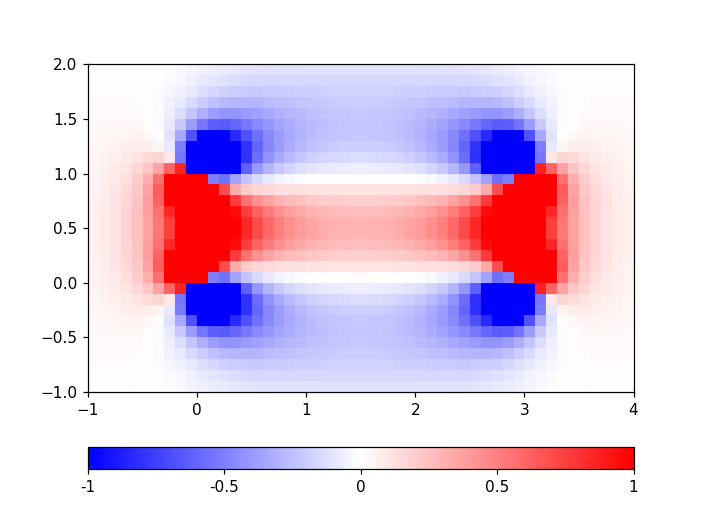

In [10]:
up = mt.extractUpperSurface2dMesh(mesh)
pg.show(up, "sens", **kwargs);

We draw a 2D slice through the middle

<IPython.core.display.Javascript object>


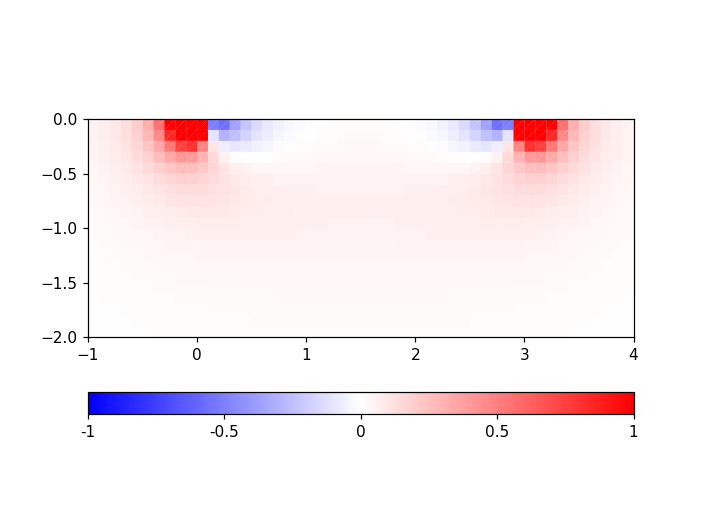

In [11]:
pg.show(mt.extract2dSlice(mesh, origin=[0, 0.05, 0], angle=0), "sens", **kwargs);

<IPython.core.display.Javascript object>


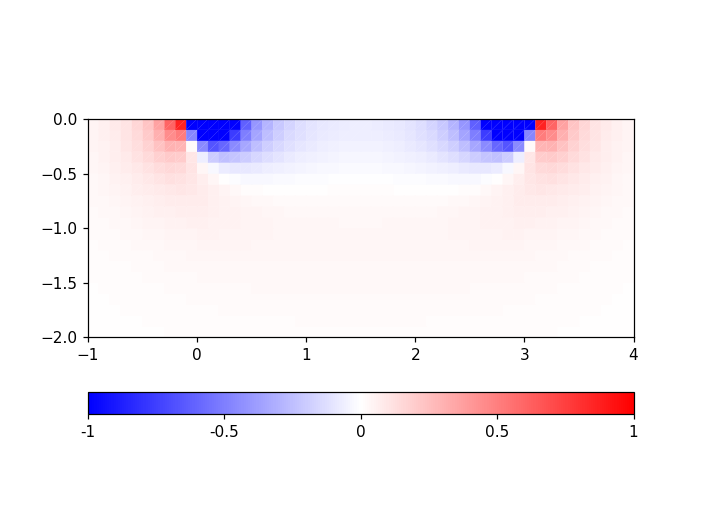

In [12]:
pg.show(mt.extract2dSlice(mesh, origin=[0, -0.05, 0], angle=0), "sens", **kwargs);

Apparently, there is quite some change in the line between A and M. Let's look in the symmetry line.

<IPython.core.display.Javascript object>


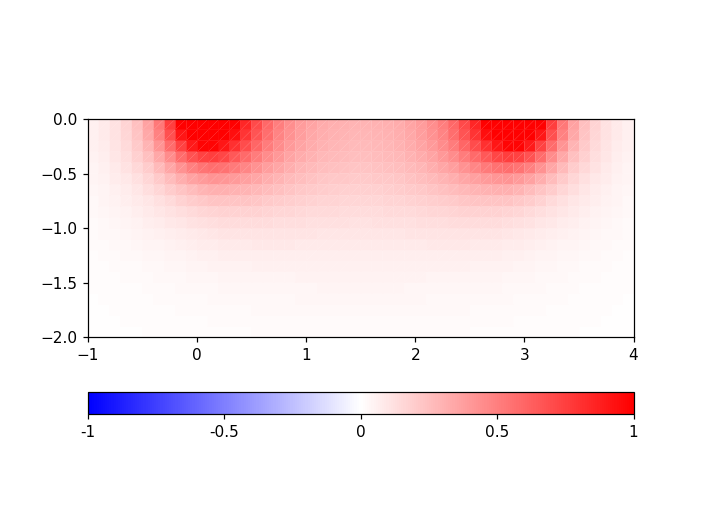

In [13]:
pg.show(mt.extract2dSlice(mesh, origin=[0, 0.5, 0], angle=0), "sens", **kwargs);

Here's a 3D image of the sensivity (only visible when running it interactively):

In [14]:
pl, _ = pg.show(mesh, label="sens", cMap="bwr", filter={"threshold": dict(value=.3, scalars="asens")})
pv.drawMesh(pl, mesh, label="sens", style="surface", **kwargs,
            filter={"slice": dict(normal=[0, 1, 0], origin=[1.5, 0.5, 0])})
pl.camera_position = "yz"
pl.camera.azimuth = -45
pl.camera.elevation = 10
pl.camera.zoom(1.3)

### References
* Günther, T. (2004): Inversion Methods and Resolution Analysis for the 2D/3D Reconstruction of Resistivity Structures from DC Measurements. PhD thesis, University of Mining and Technology, Freiberg, available on
http://nbn-resolving.de/urn:nbn:de:swb:105-4152277.
* Lueck, E.; Ruehlmann, J. (2013): Resistivity mapping with GEOPHILUS ELECTRICUS – Information about lateral and vertical soil  heterogeneity. Geoderma 199, 2-11. http://dx.doi.org/10.1016/j.geoderma.2012.11.009
* Guillemoteau, J., Lück, E. & Tronicke, J. (2017): 1D inversion of direct current data acquired with a rolling electrode system. Journal of Applied Geophysics 146, 167-176. https://doi.org/10.1016/j.jappgeo.2017.09.010